In [618]:
import scipy.io as sio
data = sio.loadmat('BaxterRhythmic.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 04 11:34:53 2015',
 '__version__': '1.0',
 '__globals__': [],
 'X_train': array([[-0.33747577,  0.9898011 , -0.96832537, ...,  0.        ,
          0.        ,  0.        ],
        [-0.33824276,  0.98903411, -0.96947586, ...,  3.14585903,
         -0.67411265,  2.24704217],
        [-0.33785927,  0.98941761, -0.96909236, ..., -0.82391546,
         -0.14980281, -1.3107746 ],
        ...,
        [-0.3113981 ,  1.00475741, -0.998238  , ..., -1.46057741,
         -0.18725351, -0.82391546],
        [-0.3110146 ,  1.00399042, -0.9978545 , ..., -1.90998584,
         -1.08607038, -1.01116898],
        [-0.3113981 ,  1.00360693, -0.99747101, ...,  1.08607038,
         -1.04861968,  0.89881687]]),
 'Y_train': array([[ -3.012,  -8.096,  -0.808, ...,   1.276,  -2.444,  -0.12 ],
        [ -2.788,  -8.064,  -0.808, ...,   1.268,  -2.452,  -0.128],
        [ -2.756,  -8.036,  -0.716, ...,   1.296,  -2.452,  -0.148],
     

In [619]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch.nn.functional as F

In [620]:
# Extract the training and testing data
X_train = torch.tensor(data['X_train'], dtype=torch.float32)
Y_train = torch.tensor(data['Y_train'], dtype=torch.float32)
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)

In [621]:
# Split the training data into train and validation sets
split_ratio = 0.9  # Adjust as needed
split_idx = int(len(X_train) * split_ratio)
X_train_split = X_train[:split_idx]
Y_train_split = Y_train[:split_idx]
X_val_split = X_train[split_idx:]
Y_val_split = Y_train[split_idx:]

In [622]:
# Calculate means and standard deviations from the training set
X_train_mean = X_train_split.mean(dim=0)
X_train_std = X_train_split.std(dim=0)

# Normalize the training set
X_train = (X_train_split - X_train_mean) / X_train_std

# Normalize the validation and test sets using the same mean and std
X_val = (X_val_split - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [623]:

#Apply data augmentation (e.g., add noise)
noise_factor = 0.01  # Adjust the noise factor as needed
X_train = X_train + noise_factor * np.random.normal(size=X_train.shape)


In [624]:
class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeterministicModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Increased hidden units and added layers
        self.batch_norm1 = nn.BatchNorm1d(256)  # Add batch normalization layer
        self.fc2 = nn.Linear(256,256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,256)
        #self.batch_norm3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with 50% dropout probability
        self.batch_norm1 = nn.BatchNorm1d(256)  # Add batch normalization layer
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.batch_norm1(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc3(x))
        #x = self.batch_norm3(x)
        x = self.fc4(x)
        #x = torch.relu(self.fc1(x))
        #x = self.batch_norm1(x)  # Apply batch normalization
        #x = self.dropout(x)  # Apply dropout
       # x = torch.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mean_layer = nn.Linear(64, output_dim)
        self.log_var_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return mean, log_var


In [666]:
# Define the L2 regularization strength
l2_reg = 0.0001

def train_model_with_validation(model, X_train, Y_train, X_val, Y_val, num_epochs=300, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)  # Apply L2 regularization

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')  # Initialize with a large value
    early_stopping_patience = 100
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(torch.tensor(X_train).float())
        loss = F.mse_loss(output, torch.tensor(Y_train).float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(torch.tensor(X_val).float())
            val_loss = F.mse_loss(val_output, torch.tensor(Y_val).float())
            val_losses.append(val_loss.item())

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Train the Deterministic model with train-validation split
deterministic_model = DeterministicModel(input_dim=X_train_split.shape[1], output_dim=Y_train_split.shape[1])
det_train_losses, det_val_losses = train_model_with_validation(
    deterministic_model, X_train_split, Y_train_split, X_val_split, Y_val_split
)

C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\1036364647.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(X_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\1036364647.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.mse_loss(output, torch.tensor(Y_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\1036364647.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_output = model(torch.tensor(X_val).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\1

Epoch [1/300] - Train Loss: 47.4103 - Val Loss: 61.2700
Epoch [2/300] - Train Loss: 46.1046 - Val Loss: 60.9141
Epoch [3/300] - Train Loss: 44.8342 - Val Loss: 60.5684
Epoch [4/300] - Train Loss: 43.5812 - Val Loss: 60.1778
Epoch [5/300] - Train Loss: 42.3191 - Val Loss: 59.6953
Epoch [6/300] - Train Loss: 41.0030 - Val Loss: 59.0884
Epoch [7/300] - Train Loss: 39.7122 - Val Loss: 58.3350
Epoch [8/300] - Train Loss: 38.3497 - Val Loss: 57.4180
Epoch [9/300] - Train Loss: 36.9069 - Val Loss: 56.3164
Epoch [10/300] - Train Loss: 35.6171 - Val Loss: 55.0182
Epoch [11/300] - Train Loss: 34.1507 - Val Loss: 53.5203
Epoch [12/300] - Train Loss: 32.7006 - Val Loss: 51.8198
Epoch [13/300] - Train Loss: 31.2340 - Val Loss: 49.9208
Epoch [14/300] - Train Loss: 29.8441 - Val Loss: 47.8298
Epoch [15/300] - Train Loss: 28.2723 - Val Loss: 45.5640
Epoch [16/300] - Train Loss: 26.8214 - Val Loss: 43.1419
Epoch [17/300] - Train Loss: 25.2867 - Val Loss: 40.5980
Epoch [18/300] - Train Loss: 23.7663 - V

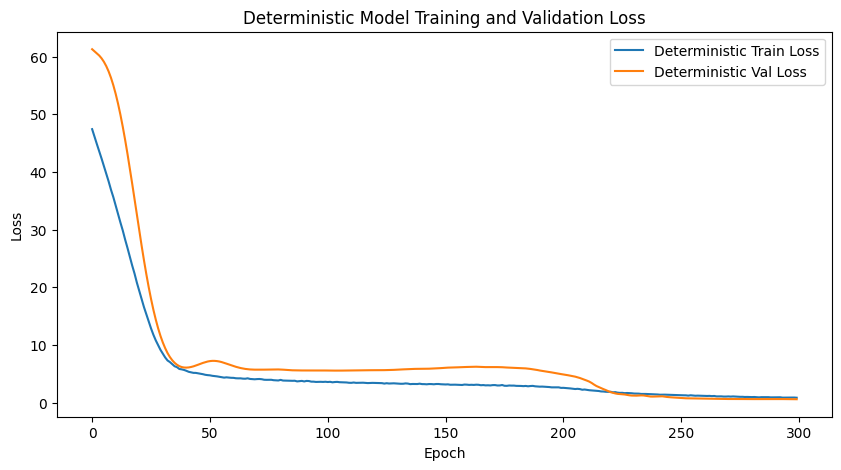

In [667]:
# Plot train and val losses for the Deterministic model
plt.figure(figsize=(10, 5))
plt.plot(det_train_losses, label='Deterministic Train Loss')
plt.plot(det_val_losses, label='Deterministic Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deterministic Model Training and Validation Loss')
plt.legend()
plt.show()

In [630]:
def train_gaussian_model_with_validation(model, X_train, Y_train, X_val, Y_val, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mean, log_var = model(torch.tensor(X_train).float())
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        normal = torch.distributions.Normal(mean, std)
        log_likelihood = normal.log_prob(torch.tensor(Y_train).float())
        loss = -log_likelihood.mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_mean, val_log_var = model(torch.tensor(X_val).float())
            val_std = torch.exp(0.5 * val_log_var)
            val_normal = torch.distributions.Normal(val_mean, val_std)
            val_log_likelihood = val_normal.log_prob(torch.tensor(Y_val).float())
            val_loss = -val_log_likelihood.mean()
            val_losses.append(val_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Train the Gaussian model with train-validation split
gaussian_model = GaussianModel(input_dim=X_train_split.shape[1], output_dim=Y_train_split.shape[1])
gaussian_train_losses, gaussian_val_losses = train_gaussian_model_with_validation(
    gaussian_model, X_train_split, Y_train_split, X_val_split, Y_val_split
)

C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\4107129447.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, log_var = model(torch.tensor(X_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\4107129447.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_likelihood = normal.log_prob(torch.tensor(Y_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_10092\4107129447.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_mean, val_log_var = model(torch.tensor(X_val).float())
C:\Users\jimts\AppData\Loc

Epoch [1/100] - Train Loss: 24.9225 - Val Loss: 31.5584
Epoch [2/100] - Train Loss: 24.1102 - Val Loss: 30.4720
Epoch [3/100] - Train Loss: 23.3164 - Val Loss: 29.4074
Epoch [4/100] - Train Loss: 22.5368 - Val Loss: 28.3586
Epoch [5/100] - Train Loss: 21.7670 - Val Loss: 27.3215
Epoch [6/100] - Train Loss: 21.0029 - Val Loss: 26.2895
Epoch [7/100] - Train Loss: 20.2408 - Val Loss: 25.2586
Epoch [8/100] - Train Loss: 19.4786 - Val Loss: 24.2274
Epoch [9/100] - Train Loss: 18.7136 - Val Loss: 23.1937
Epoch [10/100] - Train Loss: 17.9456 - Val Loss: 22.1596
Epoch [11/100] - Train Loss: 17.1735 - Val Loss: 21.1229
Epoch [12/100] - Train Loss: 16.3979 - Val Loss: 20.0864
Epoch [13/100] - Train Loss: 15.6196 - Val Loss: 19.0511
Epoch [14/100] - Train Loss: 14.8407 - Val Loss: 18.0196
Epoch [15/100] - Train Loss: 14.0635 - Val Loss: 16.9968
Epoch [16/100] - Train Loss: 13.2910 - Val Loss: 15.9870
Epoch [17/100] - Train Loss: 12.5269 - Val Loss: 14.9947
Epoch [18/100] - Train Loss: 11.7747 - V

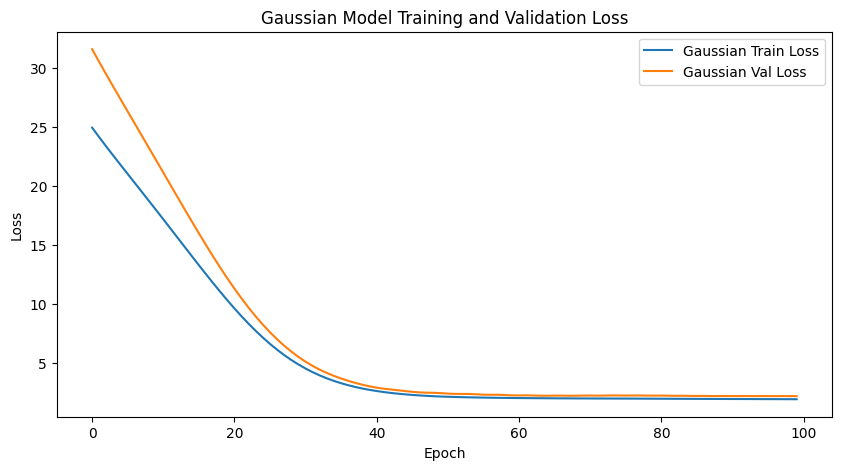

In [631]:
# Plot train and val losses for the Gaussian model
plt.figure(figsize=(10, 5))
plt.plot(gaussian_train_losses, label='Gaussian Train Loss')
plt.plot(gaussian_val_losses, label='Gaussian Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian Model Training and Validation Loss')
plt.legend()
plt.show()

In [668]:
import scipy.stats as stats

def evaluate_deterministic_model(model, X_data, Y_data):
    model.eval()
    outputs = model(X_data)
    all_predictions = outputs.detach().numpy()
    all_targets = Y_data.numpy()

    # Calculate the mean squared error (MSE)
    mse = ((all_predictions - all_targets) ** 2).mean()

    # Calculate the p-value using the t-test
    _, p_value = stats.ttest_rel(all_predictions, all_targets)

    # Convert the p-value array to a scalar value (e.g., by taking the mean)
    p_value_scalar = np.mean(p_value)

    return mse, p_value_scalar

# Evaluate the deterministic model on the test set
deterministic_mse, deterministic_p_value = evaluate_deterministic_model(
    deterministic_model, X_test, Y_test
)

print("Deterministic Model:")
print(f"Mean Squared Error (MSE): {deterministic_mse:.4f}")
print(f"P-value: {deterministic_p_value:.10f}")

Deterministic Model:
Mean Squared Error (MSE): 52.0965
P-value: 0.0000000000


In [657]:
import torch
from scipy import stats

def evaluate_gaussian_model(model, X_data, Y_data):
    model.eval()
    mean, log_var = model(X_data)
    std = torch.exp(0.5 * log_var)  # Convert log_var to std

    # Add a small epsilon to std to avoid division by zero
    epsilon = 1e-8
    std = torch.clamp(std, min=epsilon)

    # Detach the tensors before converting to NumPy arrays
    mean_np = mean.detach().cpu().numpy()
    std_np = std.detach().cpu().numpy()
    y_data_np = Y_data.cpu().numpy()

    # Calculate the p-values for each predicted sample
    p_values = stats.norm.cdf(y_data_np, loc=mean_np, scale=std_np)

    # Calculate the mean p-value across all samples and dimensions
    mean_p_value = torch.mean(torch.tensor(p_values))

    return mean_p_value

# Evaluate the Gaussian model on the test set
mean_p_value = evaluate_gaussian_model(gaussian_model, X_test, Y_test)
print(f"Mean P-Value: {mean_p_value.item()}")

Mean P-Value: 0.3247985510549806
